## **Problem 5: Recurrent Neural Network (RNN)**

In [1]:
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from hazm import Normalizer, word_tokenize, stopwords_list
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Part 1.

In [3]:
df = pd.read_csv("emails.csv")
df.head()

,text,label
0,﻿ممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نک...,ham
1,﻿سلام آقای کریمی\nبالاخره آزمونارشد تموم شد من...,ham
2,﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...,ham
3,﻿با سلام و احترام\nضمن تقدیر از مسولین محترم ...,ham
4,﻿با سلام اینجانب یک دستگاه خودرو پراید 131 با ...,ham


In [4]:
normalizer = Normalizer()
stopwords = set(stopwords_list())

# Clean and tokenize Persian text
def clean_text(text: str) -> str:
    text = str(text)
    # Remove special characters (BOM, ZWNJ, LRE)
    text = (text
            .replace('\ufeff', '')
            .replace('\u200c', ' ')
            .replace('\u202a', ''))
    text = normalizer.normalize(text)

    # Remove URLs, digits (English & Persian), and Latin characters
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'[0-9۰-۹]+', '', text)
    text = re.sub(r'[A-Za-z]+', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    # Remove common Persian stopwords
    tokens = [tok for tok in tokens if tok not in stopwords]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

# Convert categorical labels to numeric
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

# Define input features and target labels
X = df['clean_text']
y = df['label_num']

df[['clean_text', 'label_num']].to_csv("Preprocessed_emails.csv", index=False, encoding='utf-8-sig')

df[['clean_text', 'label_num']].head()

,clean_text,label_num
0,ممنون آقا سامان پارسال اصلا آزاد شرکت نکرده_بو...,0
1,سلام کریمی بالاخره آزمونارشد تموم راحت شدم یکم...,0
2,درود حاج وحیدی بنده بعنوان دکتری تاریخ دستی تا...,0
3,سلام احترام تقدیر مسولین محترم سایت تابناک رسا...,0
4,سلام اینجانب دستگاه خودرو پراید شماره درخواست ...,0


In [5]:
# Split dataset into train, validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, shuffle=True, stratify=y_temp, random_state=42)

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Train set: 700 samples
Validation set: 100 samples
Test set: 200 samples


In [6]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Tokenize and fit on training data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences of word indices
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to a fixed maximum length
max_length = 200  
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

print(f"X_train_pad shape: {X_train_pad.shape}")
print(f"X_val_pad shape: {X_val_pad.shape}")
print(f"X_test_pad shape: {X_test_pad.shape}")

X_train_pad shape: (700, 200)
X_val_pad shape: (100, 200)
X_test_pad shape: (200, 200)


# Part 2.

In [7]:
# Define model parameters
vocab_size = 10000  
embedding_dim = 100  
max_length = 200  

# Build a simple RNN model
model_rnn = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    SimpleRNN(64, return_sequences=False),  
    Dense(1, activation='sigmoid') 
])

# Compile the model
model_rnn.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Callback to display epoch metrics
class PrintMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        train_acc = logs.get('accuracy')
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')
        print(f'Epoch [{epoch + 1}/20], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%')

# Train model with metrics callback
history_rnn = model_rnn.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[PrintMetrics()],
    verbose=0
    )

# Predict on test set and compute evaluation metrics
y_test_pred = (model_rnn.predict(X_test_pad) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f'\nFinal Test Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision*100:.4f}')
print(f'Recall: {recall*100:.4f}')
print(f'F1-Score: {f1*100:.4f}')

Epoch [1/20], Train Loss: 0.6737, Train Accuracy: 58.43%, Val Loss: 0.6035, Val Accuracy: 75.00%
Epoch [2/20], Train Loss: 0.6158, Train Accuracy: 70.43%, Val Loss: 0.5810, Val Accuracy: 76.00%
Epoch [3/20], Train Loss: 0.5846, Train Accuracy: 73.57%, Val Loss: 0.5754, Val Accuracy: 76.00%
Epoch [4/20], Train Loss: 0.5534, Train Accuracy: 76.57%, Val Loss: 0.6721, Val Accuracy: 62.00%
Epoch [5/20], Train Loss: 0.5906, Train Accuracy: 70.71%, Val Loss: 0.6144, Val Accuracy: 69.00%
Epoch [6/20], Train Loss: 0.4950, Train Accuracy: 82.29%, Val Loss: 0.5694, Val Accuracy: 74.00%
Epoch [7/20], Train Loss: 0.4561, Train Accuracy: 85.57%, Val Loss: 0.5564, Val Accuracy: 75.00%
Epoch [8/20], Train Loss: 0.4305, Train Accuracy: 86.86%, Val Loss: 0.5648, Val Accuracy: 74.00%
Epoch [9/20], Train Loss: 0.4131, Train Accuracy: 87.43%, Val Loss: 0.5550, Val Accuracy: 75.00%
Epoch [10/20], Train Loss: 0.3985, Train Accuracy: 87.71%, Val Loss: 0.5326, Val Accuracy: 77.00%
Epoch [11/20], Train Loss: 0.

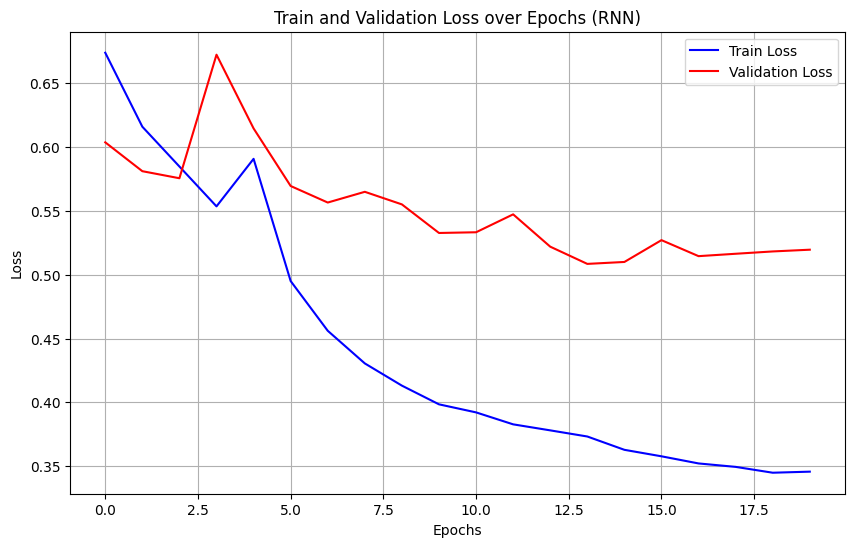

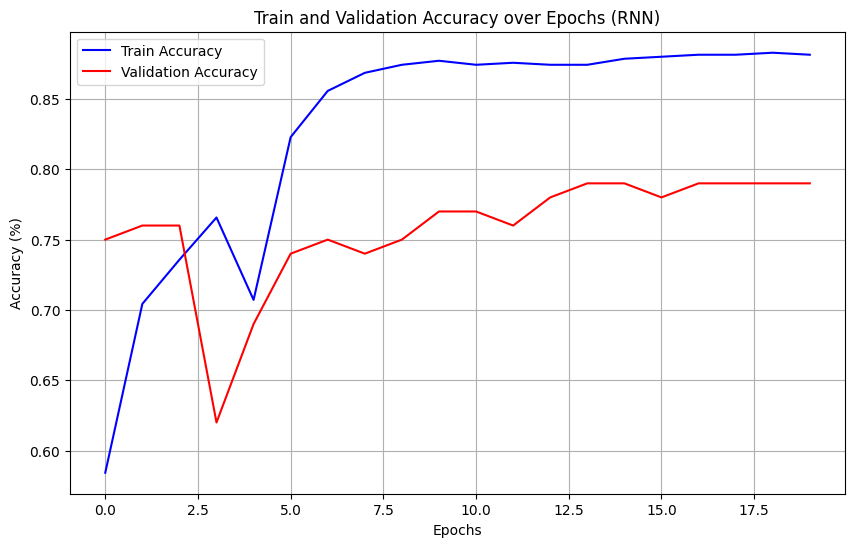

In [10]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history_rnn.history['loss'], label='Train Loss', color='blue')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs (RNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs (RNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Part 3.

In [11]:
# Define model parameters
vocab_size = 10000
embedding_dim = 100
max_length = 200

# Build LSTM model 
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=False), 
    Dense(1, activation='sigmoid')
])

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Callback to display epoch metrics
class PrintMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        train_acc = logs.get('accuracy')
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')
        print(f'Epoch [{epoch + 1}/20], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%')

# Train model with metrics callback
history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[PrintMetrics()],
    verbose=0
)

# Predict on test set and compute evaluation metrics
y_test_pred_lstm = (model_lstm.predict(X_test_pad) > 0.5).astype(int)
accuracy_lstm = accuracy_score(y_test, y_test_pred_lstm)
precision_lstm = precision_score(y_test, y_test_pred_lstm)
recall_lstm = recall_score(y_test, y_test_pred_lstm)
f1_lstm = f1_score(y_test, y_test_pred_lstm)

print(f"\nFinal Test Metrics for LSTM:")
print(f"Accuracy: {accuracy_lstm*100:.2f}%")
print(f"Precision: {precision_lstm*100:.2f}%")
print(f"Recall: {recall_lstm*100:.2f}%")
print(f"F1-Score: {f1_lstm*100:.2f}%")

Epoch [1/20], Train Loss: 0.6900, Train Accuracy: 60.14%, Val Loss: 0.6820, Val Accuracy: 61.00%
Epoch [2/20], Train Loss: 0.6817, Train Accuracy: 65.43%, Val Loss: 0.6690, Val Accuracy: 71.00%
Epoch [3/20], Train Loss: 0.6739, Train Accuracy: 68.57%, Val Loss: 0.6543, Val Accuracy: 74.00%
Epoch [4/20], Train Loss: 0.6668, Train Accuracy: 68.43%, Val Loss: 0.6401, Val Accuracy: 75.00%
Epoch [5/20], Train Loss: 0.6613, Train Accuracy: 67.86%, Val Loss: 0.6293, Val Accuracy: 75.00%
Epoch [6/20], Train Loss: 0.6557, Train Accuracy: 68.00%, Val Loss: 0.6194, Val Accuracy: 76.00%
Epoch [7/20], Train Loss: 0.6478, Train Accuracy: 67.86%, Val Loss: 0.6044, Val Accuracy: 77.00%
Epoch [8/20], Train Loss: 0.6320, Train Accuracy: 68.29%, Val Loss: 0.5658, Val Accuracy: 78.00%
Epoch [9/20], Train Loss: 0.5807, Train Accuracy: 71.14%, Val Loss: 0.5548, Val Accuracy: 68.00%
Epoch [10/20], Train Loss: 0.5603, Train Accuracy: 72.14%, Val Loss: 0.4981, Val Accuracy: 79.00%
Epoch [11/20], Train Loss: 0.

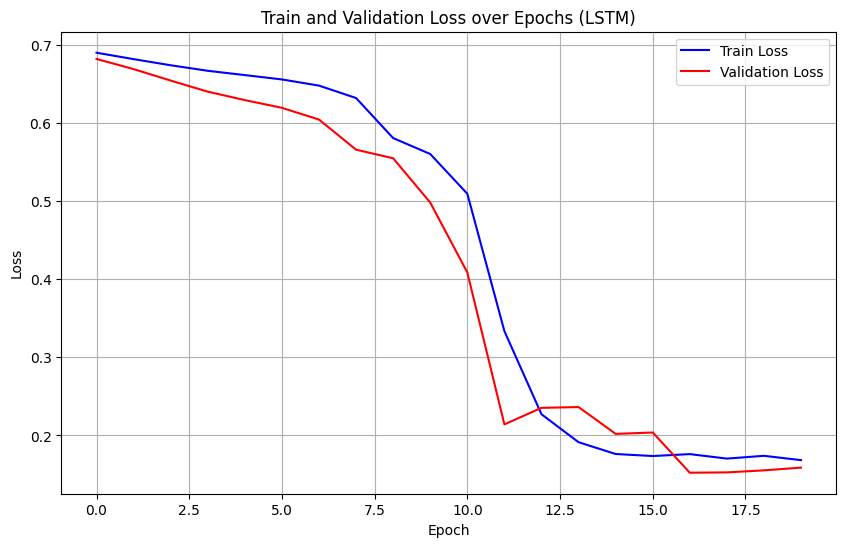

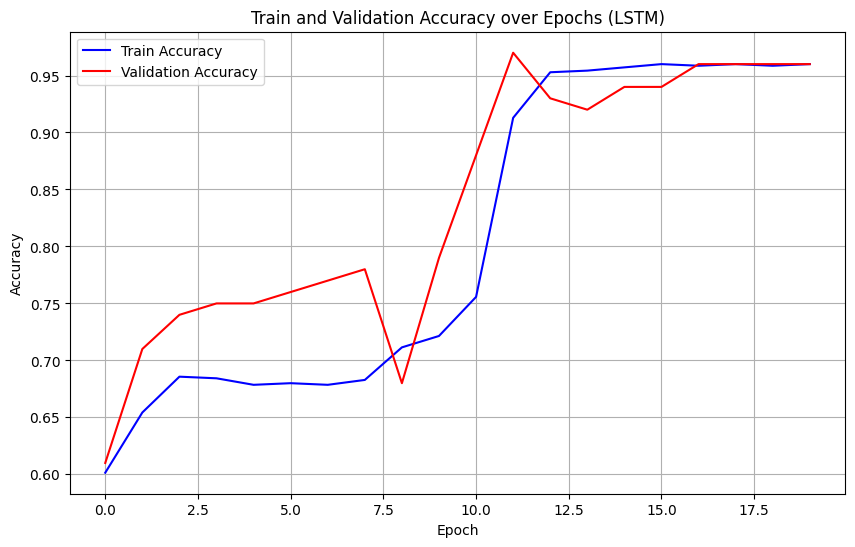

In [13]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='Train Loss', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Part 4.

*🔹Input Sequence Length*

In [14]:
# Define model parameters
vocab_size = 10000
embedding_dim = 100
lstm_units = 64
sequence_lengths = [50, 100, 300, 400]

# List of final results
results = []

for max_length in sequence_lengths:
    print(f"\nEvaluating for sequence length = {max_length}")

    X_train_pad_ = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
    X_val_pad_ = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
    X_test_pad_ = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

    # Build model
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        LSTM(units=lstm_units),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train model
    model.fit(
        X_train_pad_, y_train,
        validation_data=(X_val_pad_, y_val),
        epochs=20,
        batch_size=32,
        verbose=0
    )

    # Predict on test set and compute evaluation metrics
    y_pred = (model.predict(X_test_pad_) > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Sequence Length': max_length,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1-Score: {f1:.4f}")


Evaluating for sequence length = 50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Accuracy: 0.8850 | Precision: 0.9639 | Recall: 0.8000 | F1-Score: 0.8743

Evaluating for sequence length = 100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Accuracy: 0.8650 | Precision: 1.0000 | Recall: 0.7300 | F1-Score: 0.8439

Evaluating for sequence length = 300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Accuracy: 0.9250 | Precision: 1.0000 | Recall: 0.8500 | F1-Score: 0.9189

Evaluating for sequence length = 400
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
Accuracy: 0.5500 | Precision: 0.8571 | Recall: 0.1200 | F1-Score: 0.2105


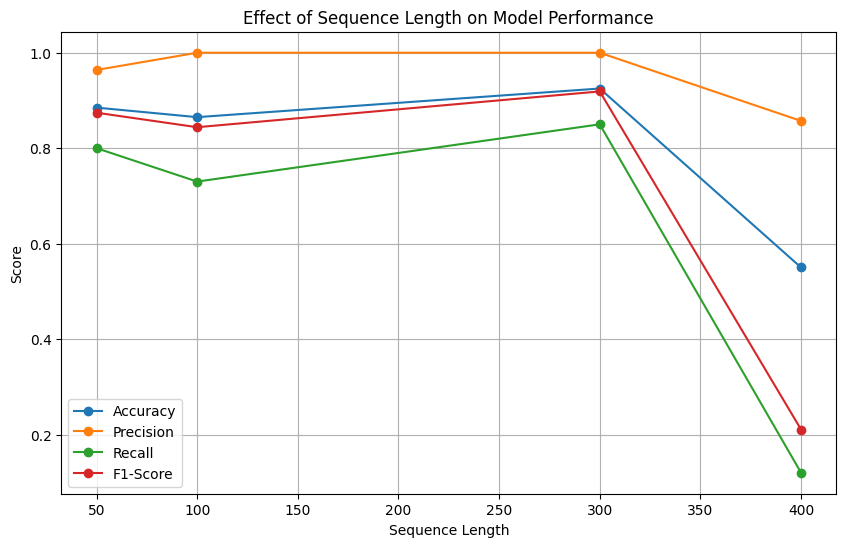

In [15]:
# Convert results to DataFrame
df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(df['Sequence Length'], df['Accuracy'], marker='o', label='Accuracy')
plt.plot(df['Sequence Length'], df['Precision'], marker='o', label='Precision')
plt.plot(df['Sequence Length'], df['Recall'], marker='o', label='Recall')
plt.plot(df['Sequence Length'], df['F1-Score'], marker='o', label='F1-Score')

plt.title('Effect of Sequence Length on Model Performance')
plt.xlabel('Sequence Length')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

*🔹Embedding Vector Dimension*

In [16]:
# Define model parameters
vocab_size = 10000
lstm_units = 64
max_length = 200  
embedding_dims = [32, 64, 128, 200]  

# List of final results
results = []

for emb_dim in embedding_dims:
    print(f"\nEvaluating for embedding_dim = {emb_dim}")

    # Build model
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_length),
        LSTM(units=lstm_units),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train model
    model.fit(
        X_train_pad_, y_train,
        validation_data=(X_val_pad_, y_val),
        epochs=20,
        batch_size=32,
        verbose=0
    )

    # Predict on test set and compute evaluation metrics
    y_pred = (model.predict(X_test_pad_) > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Embedding Dim': emb_dim,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1-Score: {f1:.4f}")


Evaluating for embedding_dim = 32
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Accuracy: 0.8550 | Precision: 0.9863 | Recall: 0.7200 | F1-Score: 0.8324

Evaluating for embedding_dim = 64
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Accuracy: 0.8900 | Precision: 0.9535 | Recall: 0.8200 | F1-Score: 0.8817

Evaluating for embedding_dim = 128
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
Accuracy: 0.5550 | Precision: 0.8667 | Recall: 0.1300 | F1-Score: 0.2261

Evaluating for embedding_dim = 200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Accuracy: 0.8800 | Precision: 1.0000 | Recall: 0.7600 | F1-Score: 0.8636


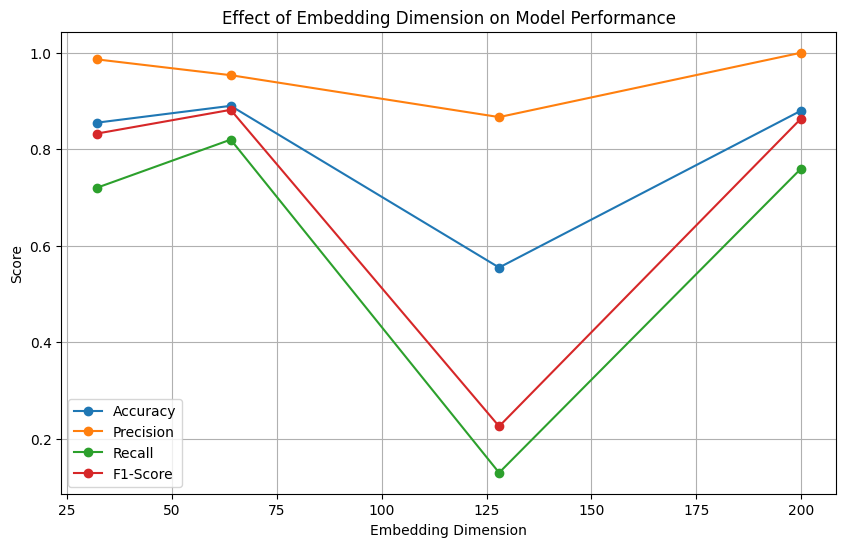

In [17]:
# Convert results to DataFrame
df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(df['Embedding Dim'], df['Accuracy'], marker='o', label='Accuracy')
plt.plot(df['Embedding Dim'], df['Precision'], marker='o', label='Precision')
plt.plot(df['Embedding Dim'], df['Recall'], marker='o', label='Recall')
plt.plot(df['Embedding Dim'], df['F1-Score'], marker='o', label='F1-Score')

plt.title('Effect of Embedding Dimension on Model Performance')
plt.xlabel('Embedding Dimension')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

*🔹 Hidden State layer of LSTM Network*

In [18]:
# Define model parameters
vocab_size = 10000
embedding_dim = 100
max_length = 200
hidden_sizes = [32, 128, 256]  

# List of final results
results = []

for hidden_units in hidden_sizes:
    print(f"\nEvaluating for LSTM hidden units = {hidden_units}")

    # Build model
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        LSTM(units=hidden_units),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train model
    model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=20,
        batch_size=32,
        verbose=0
    )

    # Predict on test set and compute evaluation metrics
    y_pred = (model.predict(X_test_pad) > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Hidden Units': hidden_units,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1-Score: {f1:.4f}")


Evaluating for LSTM hidden units = 32
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Accuracy: 0.9500 | Precision: 0.9688 | Recall: 0.9300 | F1-Score: 0.9490

Evaluating for LSTM hidden units = 128
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Accuracy: 0.8550 | Precision: 0.9863 | Recall: 0.7200 | F1-Score: 0.8324

Evaluating for LSTM hidden units = 256
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
Accuracy: 0.8400 | Precision: 0.9857 | Recall: 0.6900 | F1-Score: 0.8118


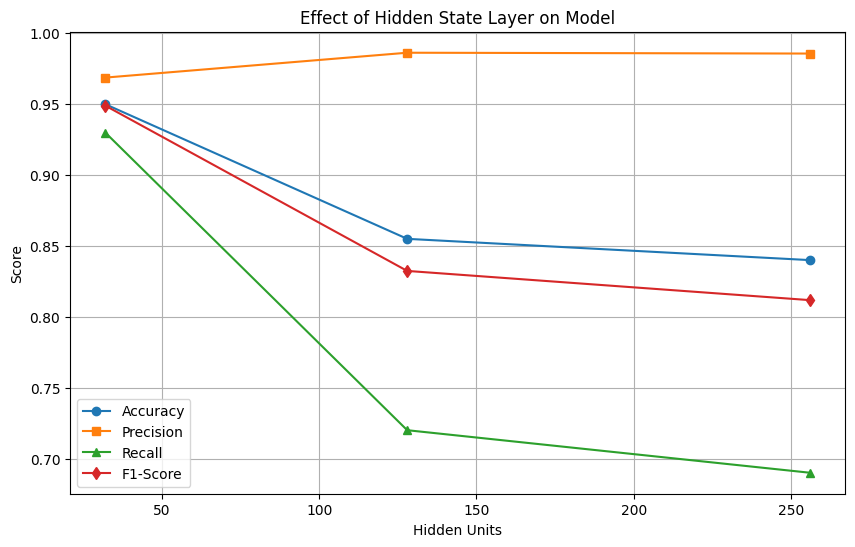

In [19]:
# Convert results to DataFrame
df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(df['Hidden Units'], df['Accuracy'], label='Accuracy', marker='o')
plt.plot(df['Hidden Units'], df['Precision'], label='Precision', marker='s')
plt.plot(df['Hidden Units'], df['Recall'], label='Recall', marker='^')
plt.plot(df['Hidden Units'], df['F1-Score'], label='F1-Score', marker='d')
plt.title('Effect of Hidden State Layer on Model')
plt.xlabel('Hidden Units')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

*🔹 Effect of Dropout Usage*

In [20]:
## Without Dropout

# Define model parameters
vocab_size = 10000
embedding_dim = 100
max_length = 200

# Build LSTM model 
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=False), 
    Dense(1, activation='sigmoid')
])

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# Callback to display epoch metrics
class PrintMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        train_acc = logs.get('accuracy')
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')
        print(f'Epoch [{epoch + 1}/20], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%')

# Train model with metrics callback
history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[PrintMetrics()],
    verbose=0
)

# Predict on test set and compute evaluation metrics
y_test_pred_lstm = (model_lstm.predict(X_test_pad) > 0.5).astype(int)
accuracy_lstm = accuracy_score(y_test, y_test_pred_lstm)
precision_lstm = precision_score(y_test, y_test_pred_lstm)
recall_lstm = recall_score(y_test, y_test_pred_lstm)
f1_lstm = f1_score(y_test, y_test_pred_lstm)

print(f"\nFinal Test Metrics for LSTM:")
print(f"Accuracy: {accuracy_lstm*100:.2f}%")
print(f"Precision: {precision_lstm*100:.2f}%")
print(f"Recall: {recall_lstm*100:.2f}%")
print(f"F1-Score: {f1_lstm*100:.2f}%")

Epoch [1/20], Train Loss: 0.6890, Train Accuracy: 62.71%, Val Loss: 0.6780, Val Accuracy: 73.00%
Epoch [2/20], Train Loss: 0.6798, Train Accuracy: 66.29%, Val Loss: 0.6639, Val Accuracy: 74.00%
Epoch [3/20], Train Loss: 0.6719, Train Accuracy: 68.57%, Val Loss: 0.6495, Val Accuracy: 75.00%
Epoch [4/20], Train Loss: 0.6652, Train Accuracy: 68.14%, Val Loss: 0.6364, Val Accuracy: 75.00%
Epoch [5/20], Train Loss: 0.6596, Train Accuracy: 68.00%, Val Loss: 0.6253, Val Accuracy: 75.00%
Epoch [6/20], Train Loss: 0.6532, Train Accuracy: 68.00%, Val Loss: 0.6134, Val Accuracy: 77.00%
Epoch [7/20], Train Loss: 0.6432, Train Accuracy: 68.14%, Val Loss: 0.5933, Val Accuracy: 78.00%
Epoch [8/20], Train Loss: 0.6188, Train Accuracy: 68.57%, Val Loss: 0.5318, Val Accuracy: 78.00%
Epoch [9/20], Train Loss: 0.5689, Train Accuracy: 70.43%, Val Loss: 0.4798, Val Accuracy: 81.00%
Epoch [10/20], Train Loss: 0.5022, Train Accuracy: 77.29%, Val Loss: 0.3409, Val Accuracy: 93.00%
Epoch [11/20], Train Loss: 0.

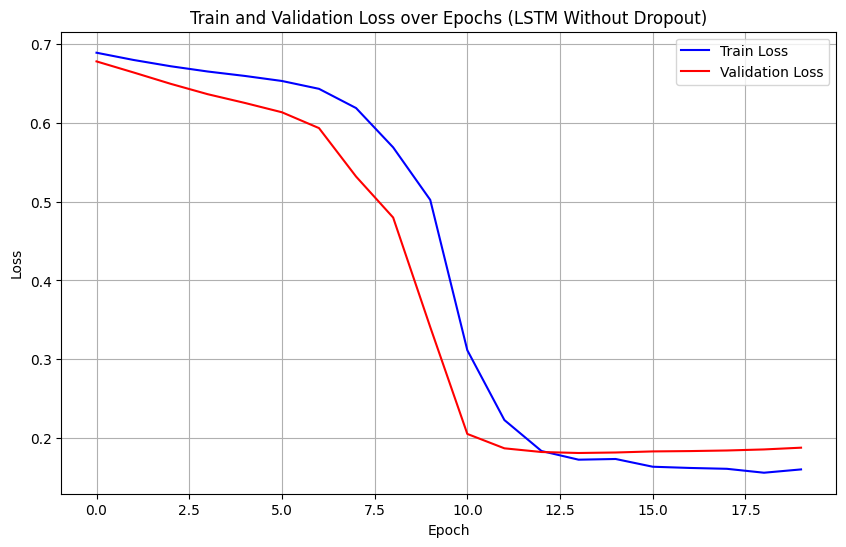

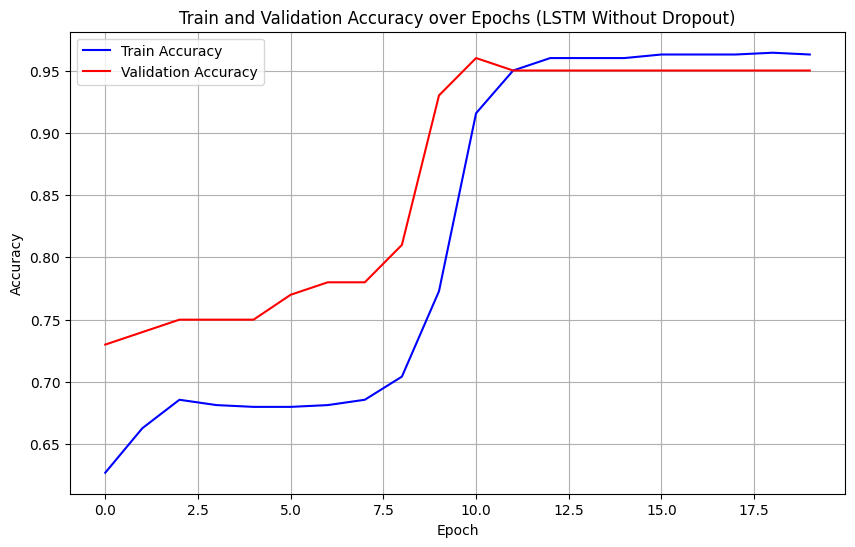

In [22]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='Train Loss', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs (LSTM Without Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs (LSTM Without Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## With Dropout

# Define model parameters
vocab_size = 10000
embedding_dim = 100
max_length = 200

# Build LSTM model
model_lstm_dropout = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=False),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_lstm_dropout.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Callback to display epoch metrics
class PrintMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        train_acc = logs.get('accuracy')
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')
        print(f'Epoch [{epoch + 1}/20], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%')

# Train model with metrics callback
history_lstm_dropout = model_lstm_dropout.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[PrintMetrics()],
    verbose=0
)

# Predict on test set and compute evaluation metrics
y_test_pred_dropout = (model_lstm_dropout.predict(X_test_pad) > 0.5).astype(int)
accuracy_dropout = accuracy_score(y_test, y_test_pred_dropout)
precision_dropout = precision_score(y_test, y_test_pred_dropout)
recall_dropout = recall_score(y_test, y_test_pred_dropout)
f1_dropout = f1_score(y_test, y_test_pred_dropout)

print(f"\nFinal Test Metrics for LSTM with Dropout:")
print(f"Accuracy: {accuracy_dropout*100:.2f}%")
print(f"Precision: {precision_dropout*100:.2f}%")
print(f"Recall: {recall_dropout*100:.2f}%")
print(f"F1-Score: {f1_dropout*100:.2f}%")


Epoch [1/20], Train Loss: 0.6905, Train Accuracy: 55.71%, Val Loss: 0.6824, Val Accuracy: 67.00%
Epoch [2/20], Train Loss: 0.6825, Train Accuracy: 64.00%, Val Loss: 0.6712, Val Accuracy: 70.00%
Epoch [3/20], Train Loss: 0.6772, Train Accuracy: 66.57%, Val Loss: 0.6600, Val Accuracy: 73.00%
Epoch [4/20], Train Loss: 0.6708, Train Accuracy: 68.00%, Val Loss: 0.6481, Val Accuracy: 75.00%
Epoch [5/20], Train Loss: 0.6664, Train Accuracy: 68.00%, Val Loss: 0.6383, Val Accuracy: 75.00%
Epoch [6/20], Train Loss: 0.6625, Train Accuracy: 68.00%, Val Loss: 0.6299, Val Accuracy: 75.00%
Epoch [7/20], Train Loss: 0.6580, Train Accuracy: 68.00%, Val Loss: 0.6227, Val Accuracy: 75.00%
Epoch [8/20], Train Loss: 0.6495, Train Accuracy: 67.86%, Val Loss: 0.6110, Val Accuracy: 77.00%
Epoch [9/20], Train Loss: 0.6398, Train Accuracy: 67.86%, Val Loss: 0.5945, Val Accuracy: 78.00%
Epoch [10/20], Train Loss: 0.6314, Train Accuracy: 68.14%, Val Loss: 0.5667, Val Accuracy: 78.00%
Epoch [11/20], Train Loss: 0.

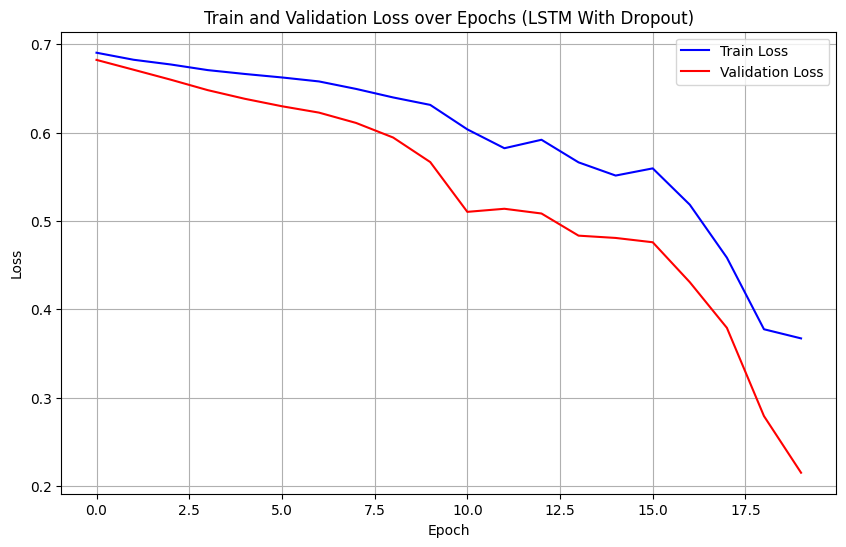

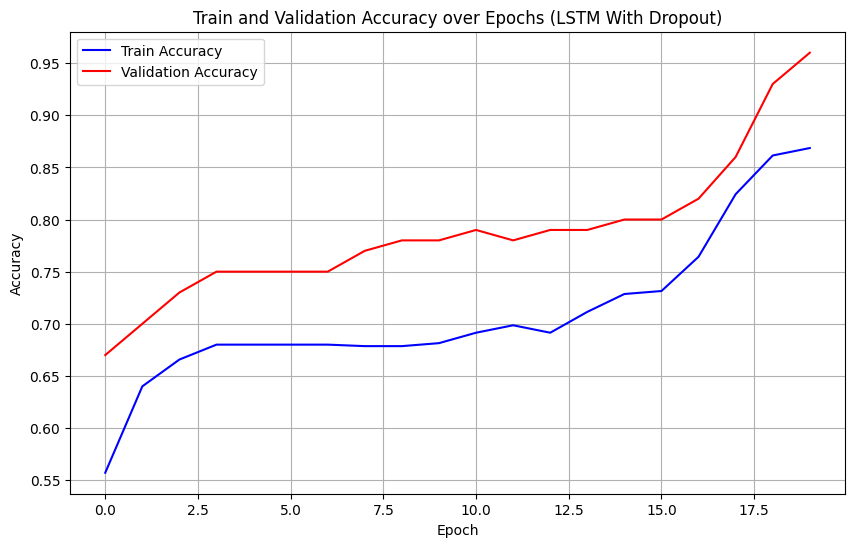

In [25]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history_lstm_dropout.history['loss'], label='Train Loss', color='blue')
plt.plot(history_lstm_dropout.history['val_loss'], label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs (LSTM With Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_lstm_dropout.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_lstm_dropout.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs (LSTM With Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Part 5.

In [26]:
# Define model parameters
vocab_size = 10000
embedding_dim = 100
max_length = 200
lstm_units = 64

# Build Bidirectional LSTM model
model_Bidirectional = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(units=lstm_units)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_Bidirectional.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
# Callback to display epoch metrics
class PrintMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        train_acc = logs.get('accuracy')
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')
        print(f'Epoch [{epoch + 1}/20], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%')

# Train model with metrics callback
history_Bidirectional = model_Bidirectional.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[PrintMetrics()],
    verbose=0
)

# Predict on test set and compute evaluation metrics
y_pred_bi = (model_Bidirectional.predict(X_test_pad) > 0.5).astype(int)
accuracy_bi = accuracy_score(y_test, y_pred_bi)
precision_bi = precision_score(y_test, y_pred_bi)
recall_bi = recall_score(y_test, y_pred_bi)
f1_bi = f1_score(y_test, y_pred_bi)

print("\nTest Metrics for Bidirectional LSTM:")
print(f"Accuracy: {accuracy_bi * 100:.2f}%")
print(f"Precision: {precision_bi * 100:.2f}%")
print(f"Recall: {recall_bi * 100:.2f}%")
print(f"F1-Score: {f1_bi * 100:.2f}%")

Epoch [1/20], Train Loss: 0.6909, Train Accuracy: 55.14%, Val Loss: 0.6812, Val Accuracy: 69.00%
Epoch [2/20], Train Loss: 0.6794, Train Accuracy: 67.14%, Val Loss: 0.6664, Val Accuracy: 72.00%
Epoch [3/20], Train Loss: 0.6667, Train Accuracy: 70.43%, Val Loss: 0.6474, Val Accuracy: 75.00%
Epoch [4/20], Train Loss: 0.6465, Train Accuracy: 71.00%, Val Loss: 0.6166, Val Accuracy: 76.00%
Epoch [5/20], Train Loss: 0.5751, Train Accuracy: 73.71%, Val Loss: 0.4716, Val Accuracy: 81.00%
Epoch [6/20], Train Loss: 0.3884, Train Accuracy: 86.43%, Val Loss: 0.3316, Val Accuracy: 87.00%
Epoch [7/20], Train Loss: 0.2873, Train Accuracy: 92.86%, Val Loss: 0.3117, Val Accuracy: 87.00%
Epoch [8/20], Train Loss: 0.2562, Train Accuracy: 92.29%, Val Loss: 0.2833, Val Accuracy: 89.00%
Epoch [9/20], Train Loss: 0.2171, Train Accuracy: 94.29%, Val Loss: 0.2597, Val Accuracy: 90.00%
Epoch [10/20], Train Loss: 0.1924, Train Accuracy: 95.14%, Val Loss: 0.2408, Val Accuracy: 90.00%
Epoch [11/20], Train Loss: 0.

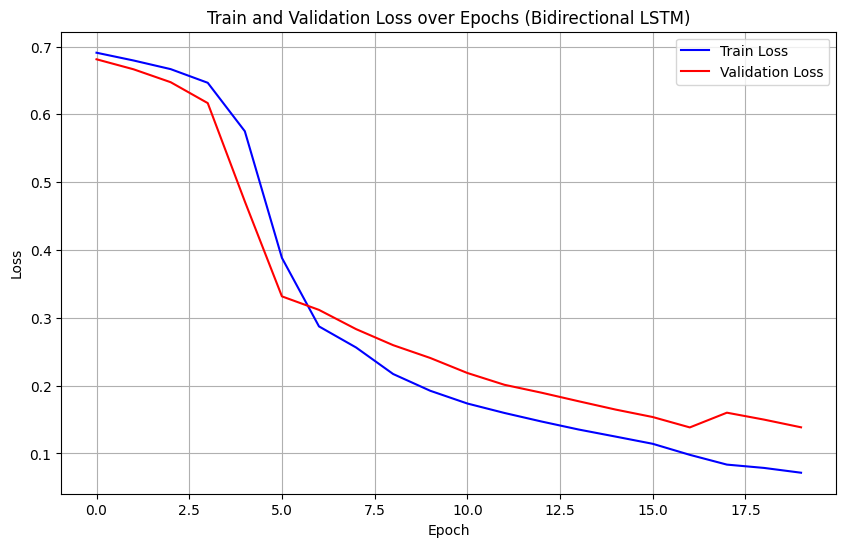

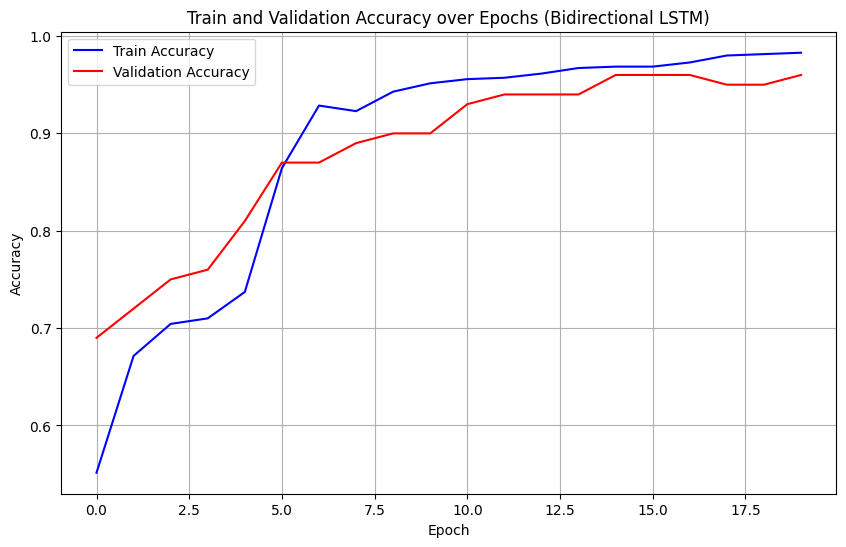

In [28]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history_Bidirectional.history['loss'], label='Train Loss', color='blue')
plt.plot(history_Bidirectional.history['val_loss'], label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs (Bidirectional LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_Bidirectional.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_Bidirectional.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs (Bidirectional LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Part 6.

1-layer

In [29]:
# Define model parameters
vocab_size = 10000
embedding_dim = 100
max_length = 200
lstm_units = 64

# Build CNN + LSTM model (1 Conv layer)
model_cnn_lstm_1 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(units=lstm_units),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_cnn_lstm_1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
# Callback to display epoch metrics
class PrintMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        train_acc = logs.get('accuracy')
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')
        print(f"Epoch [{epoch + 1}/20], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%")

# Train model with metrics callback
history_cnn_lstm_1 = model_cnn_lstm_1.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[PrintMetrics()],
    verbose=0
)

# Predict on test set and compute evaluation metrics
y_pred_cnn_lstm_1 = (model_cnn_lstm_1.predict(X_test_pad) > 0.5).astype(int)
acc1 = accuracy_score(y_test, y_pred_cnn_lstm_1)
prec1 = precision_score(y_test, y_pred_cnn_lstm_1)
rec1 = recall_score(y_test, y_pred_cnn_lstm_1)
f1_1 = f1_score(y_test, y_pred_cnn_lstm_1)

print("\nTest Metrics for CNN + LSTM (1 Conv layer):")
print(f"Accuracy: {acc1 * 100:.2f}%")
print(f"Precision: {prec1 * 100:.2f}%")
print(f"Recall: {rec1 * 100:.2f}%")
print(f"F1-Score: {f1_1 * 100:.2f}%")

Epoch [1/20], Train Loss: 0.6883, Train Accuracy: 65.71%, Val Loss: 0.6782, Val Accuracy: 78.00%
Epoch [2/20], Train Loss: 0.6792, Train Accuracy: 68.00%, Val Loss: 0.6629, Val Accuracy: 78.00%
Epoch [3/20], Train Loss: 0.6663, Train Accuracy: 68.14%, Val Loss: 0.6365, Val Accuracy: 78.00%
Epoch [4/20], Train Loss: 0.6463, Train Accuracy: 67.86%, Val Loss: 0.5958, Val Accuracy: 78.00%
Epoch [5/20], Train Loss: 0.6144, Train Accuracy: 69.00%, Val Loss: 0.5284, Val Accuracy: 78.00%
Epoch [6/20], Train Loss: 0.5581, Train Accuracy: 71.43%, Val Loss: 0.4599, Val Accuracy: 79.00%
Epoch [7/20], Train Loss: 0.4836, Train Accuracy: 74.29%, Val Loss: 0.3648, Val Accuracy: 86.00%
Epoch [8/20], Train Loss: 0.2974, Train Accuracy: 89.57%, Val Loss: 0.1784, Val Accuracy: 95.00%
Epoch [9/20], Train Loss: 0.2009, Train Accuracy: 95.00%, Val Loss: 0.3360, Val Accuracy: 87.00%
Epoch [10/20], Train Loss: 0.1894, Train Accuracy: 94.86%, Val Loss: 0.2662, Val Accuracy: 91.00%
Epoch [11/20], Train Loss: 0.

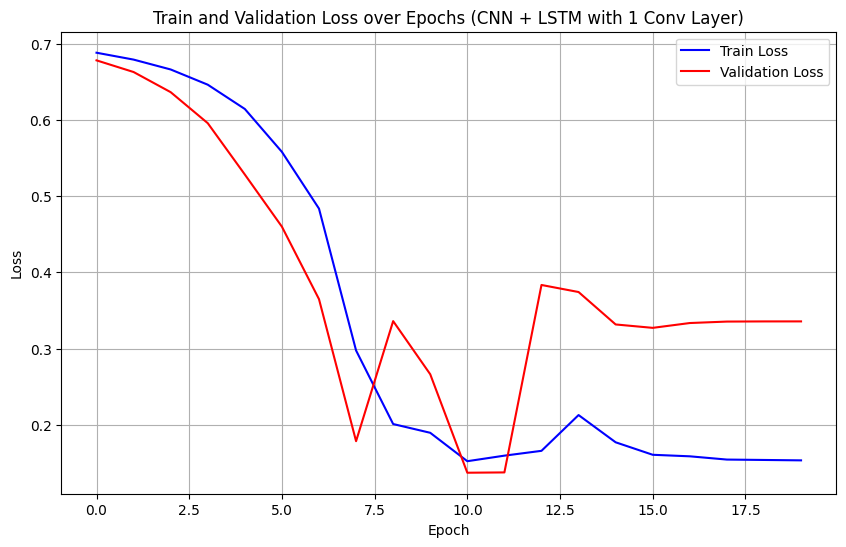

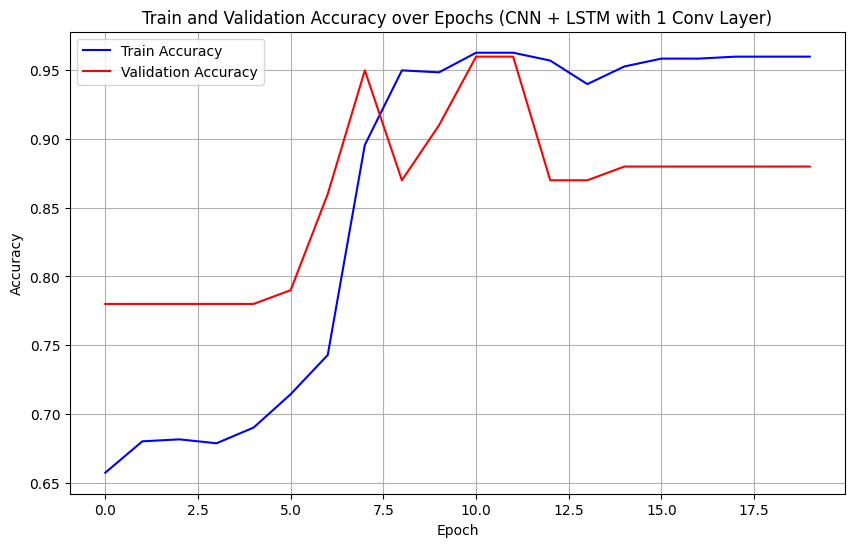

In [31]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history_cnn_lstm_1.history['loss'], label='Train Loss', color='blue')
plt.plot(history_cnn_lstm_1.history['val_loss'], label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs (CNN + LSTM with 1 Conv Layer)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy for
plt.figure(figsize=(10, 6))
plt.plot(history_cnn_lstm_1.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_cnn_lstm_1.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs (CNN + LSTM with 1 Conv Layer)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

2-layer

In [32]:
# Define model parameters
vocab_size = 10000
embedding_dim = 100
max_length = 200
lstm_units = 64

# Build CNN + LSTM model (2 Conv layers)
model_cnn_lstm_2 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(units=lstm_units),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_cnn_lstm_2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# Callback to display epoch metrics
class PrintMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        train_acc = logs.get('accuracy')
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')
        print(f"Epoch [{epoch + 1}/20], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%")

# Train model with metrics callback
history_cnn_lstm_2 = model_cnn_lstm_2.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[PrintMetrics()],
    verbose=0
)

# Predict on test set and compute evaluation metrics
y_pred_cnn_lstm_2 = (model_cnn_lstm_2.predict(X_test_pad) > 0.5).astype(int)
acc2 = accuracy_score(y_test, y_pred_cnn_lstm_2)
prec2 = precision_score(y_test, y_pred_cnn_lstm_2)
rec2 = recall_score(y_test, y_pred_cnn_lstm_2)
f1_2 = f1_score(y_test, y_pred_cnn_lstm_2)

print("\nTest Metrics for CNN + LSTM:")
print(f"Accuracy: {acc2 * 100:.2f}%")
print(f"Precision: {prec2 * 100:.2f}%")
print(f"Recall: {rec2 * 100:.2f}%")
print(f"F1-Score: {f1_2 * 100:.2f}%")

Epoch [1/20], Train Loss: 0.6886, Train Accuracy: 58.57%, Val Loss: 0.6774, Val Accuracy: 78.00%
Epoch [2/20], Train Loss: 0.6750, Train Accuracy: 69.43%, Val Loss: 0.6516, Val Accuracy: 78.00%
Epoch [3/20], Train Loss: 0.6479, Train Accuracy: 69.86%, Val Loss: 0.5926, Val Accuracy: 79.00%
Epoch [4/20], Train Loss: 0.5913, Train Accuracy: 70.86%, Val Loss: 0.4955, Val Accuracy: 77.00%
Epoch [5/20], Train Loss: 0.5326, Train Accuracy: 71.57%, Val Loss: 0.4344, Val Accuracy: 82.00%
Epoch [6/20], Train Loss: 0.4122, Train Accuracy: 80.57%, Val Loss: 0.3009, Val Accuracy: 90.00%
Epoch [7/20], Train Loss: 0.2366, Train Accuracy: 93.29%, Val Loss: 0.2273, Val Accuracy: 92.00%
Epoch [8/20], Train Loss: 0.1602, Train Accuracy: 96.14%, Val Loss: 0.1400, Val Accuracy: 96.00%
Epoch [9/20], Train Loss: 0.1544, Train Accuracy: 96.57%, Val Loss: 0.2030, Val Accuracy: 93.00%
Epoch [10/20], Train Loss: 0.1473, Train Accuracy: 96.29%, Val Loss: 0.2390, Val Accuracy: 92.00%
Epoch [11/20], Train Loss: 0.

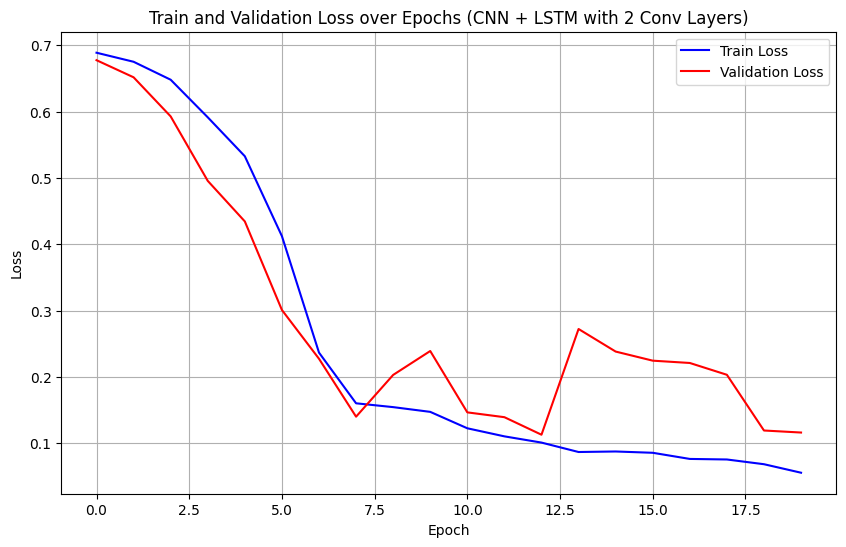

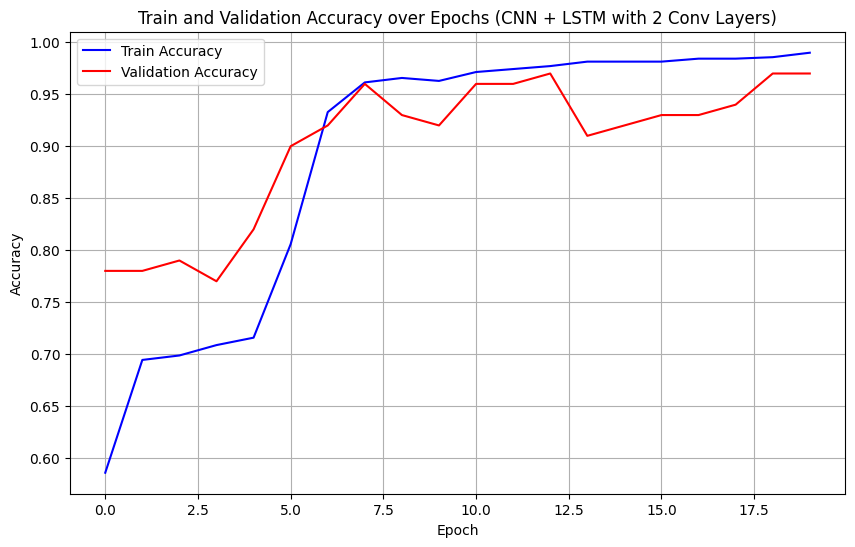

In [34]:
# Plotting Training and Validation Loss 
plt.figure(figsize=(10, 6))
plt.plot(history_cnn_lstm_2.history['loss'], label='Train Loss', color='blue')
plt.plot(history_cnn_lstm_2.history['val_loss'], label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs (CNN + LSTM with 2 Conv Layers)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy 
plt.figure(figsize=(10, 6))
plt.plot(history_cnn_lstm_2.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_cnn_lstm_2.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs (CNN + LSTM with 2 Conv Layers)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Part 7.

In [35]:
# Predict test labels using Bidirectional model
y_pred_probs = model_Bidirectional.predict(X_test_pad)
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()

# Get indices of correct and incorrect predictions
correct_indices = np.where(y_pred_labels == y_test.values)[0]
incorrect_indices = np.where(y_pred_labels != y_test.values)[0]

# Show correct predictions
print("\n- True Predictions:")
for i in correct_indices[:3]:
    print(f"\n[Label: {y_test.iloc[i]} - Predicted: {y_pred_labels[i]}]")
    print(X_test.iloc[i])

# Show incorrect predictions
print("\n- False Predictions:")
for i in incorrect_indices[:3]:
    print(f"\n[Label: {y_test.iloc[i]} - Predicted: {y_pred_labels[i]}]")
    print(X_test.iloc[i])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

- True Predictions:

[Label: 1 - Predicted: 1]
شامپو رفع سفیدی مو شامپو نیازی رنگ مو ندارید محصول شماره مجوز میباشد شامپو رفع سفیدی مو سال جوان شوید شامپو نیازی رنگ مو ندارید دقیقهبا موهای سفید خداحافظی محصولی بینظیر استثنایی بازگرداندن موهای مشکی بهترینمحصول زمینه رفع سفیدی مو نگران موهای سفید چهره پیر نباشید نیازی هزینههای گزاف وقت ندارید طرز استفاده آسان شگفتزده فروش ایران همراه کتاب آرایش مدرن بعنوان هدیه قیمت تومان خرید پستی خرید پستی محصول محصولات مراقبتی موی سر میباشد ایران عرضهشده محصول پایهی گیاهی نهتنها ضرری موهای مفید میباشد فرمول شامپو مرکز تحقیقات بینالمللی تحقیقات اساس خصوصیات موی سر مردان شرقی بدست چندین تست آزمایش عرضه محصولی دقیقه موهای سفید پوشش میدهد راجوانتر نشان میدهد قیمت تومان خرید پستی خرید پستی امکانات قابلیتها بردن سفیدی مو جوانی حفظ هرگز چهره پیر نبینید رنگدانههای مو تاثیر گذاشته رنگ طبیعی میگرداند دکلره تقویت مو ضد شوره محصول یکبار تجربه قیمت تومان خرید پستی خرید پستی طریقه مصرف استفاده محلول سادگی استفاده شامپوهای معمو